# AI-Based Forest Fire & Smoke Detection

This project aims to detect forest fire and smoke regions using machine learning
on features extracted from aerial imagery. Each image tile is represented using
spectral, intensity, and texture-based features, and a classification model is
trained to predict the presence of fire or smoke.

The system can support early disaster detection and drone-based monitoring by
identifying high-risk regions.


In [2]:
# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Plot settings
plt.style.use("seaborn-v0_8")


## Dataset Description

The dataset consists of features extracted from aerial image tiles of forest regions.
Each row represents a single spatial tile, and columns capture visual characteristics
such as color intensity, texture, haze, and thermal indicators.

The target variable `fire_label` indicates:
- `0` → No fire or smoke
- `1` → Fire or smoke present


In [3]:
# Load dataset (CSV is in the same folder as notebook)
df = pd.read_csv("fire_smoke_dataset.csv")

# Display first few rows
df.head()


,mean_red,mean_green,mean_blue,red_blue_ratio,intensity_std,edge_density,smoke_whiteness,haze_index,hot_pixel_fraction,local_contrast,fire_label
0,0.523653,0.299277,0.265874,1.962171,0.068402,0.223412,0.472959,0.333490,0.158385,0.524992,0
1,0.724041,0.394328,0.453850,1.591822,0.290540,0.345590,0.384785,0.404510,0.222511,0.100019,1
2,0.732028,0.492876,0.555428,1.315584,0.264537,0.330369,0.705461,0.625930,0.359686,0.701875,1
3,0.589471,0.527046,0.536978,1.095716,0.136997,0.458620,0.361735,0.367842,0.073597,0.777261,0
4,0.385249,0.669345,0.473443,0.812004,0.262034,0.295832,0.294756,0.702075,0.221406,0.610500,0


In [5]:
df.shape

(3000, 11)

In [7]:
df.info

<bound method DataFrame.info of       mean_red  mean_green  mean_blue  red_blue_ratio  intensity_std  \
0     0.523653    0.299277   0.265874        1.962171       0.068402   
1     0.724041    0.394328   0.453850        1.591822       0.290540   
2     0.732028    0.492876   0.555428        1.315584       0.264537   
3     0.589471    0.527046   0.536978        1.095716       0.136997   
4     0.385249    0.669345   0.473443        0.812004       0.262034   
...        ...         ...        ...             ...            ...   
2995  0.850983    0.404330   0.375418        2.260739       0.195440   
2996  0.404829    0.422685   0.331614        1.217114       0.075921   
2997  0.487928    0.584428   0.217449        2.233604       0.096826   
2998  0.520066    0.588450   0.505704        1.026370       0.130731   
2999  0.654084    0.475203   0.330417        1.973597       0.214846   

      edge_density  smoke_whiteness  haze_index  hot_pixel_fraction  \
0         0.223412         0.472

In [6]:
df.describe()

,mean_red,mean_green,mean_blue,red_blue_ratio,intensity_std,edge_density,smoke_whiteness,haze_index,hot_pixel_fraction,local_contrast,fire_label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.518938,0.448972,0.402150,1.389752,0.177488,0.298231,0.451353,0.448115,0.172722,0.500876,0.353000
std,0.156641,0.096770,0.101042,0.645881,0.076539,0.100044,0.128224,0.151640,0.148877,0.152486,0.477982
min,0.007396,0.057760,0.067889,0.023168,-0.050154,-0.065509,0.054665,-0.079923,0.000024,-0.002723,0.000000
25%,0.406602,0.383908,0.334892,0.967969,0.124140,0.228201,0.362181,0.347613,0.056877,0.398500,0.000000
50%,0.512438,0.449158,0.401911,1.283325,0.171093,0.297301,0.443042,0.447587,0.130256,0.502897,0.000000
75%,0.626587,0.513919,0.469644,1.656747,0.223977,0.366417,0.533889,0.553470,0.246473,0.602656,1.000000
max,1.039171,0.787777,0.742891,10.432023,0.440258,0.661135,0.904803,0.952231,0.924168,1.010847,1.000000


## Feature Understanding

- **mean_red, mean_green, mean_blue**: Average RGB intensities.
  Fire regions tend to show higher red intensity and lower green values.
- **red_blue_ratio**: High values indicate flame dominance.
- **intensity_std**: Measures intensity variation; fire regions are visually unstable.
- **edge_density**: Indicates structural complexity caused by flames or smoke.
- **smoke_whiteness**: Higher values correspond to smoke-covered areas.
- **haze_index**: Captures atmospheric haze due to smoke particles.
- **hot_pixel_fraction**: Fraction of pixels with high thermal intensity.
- **local_contrast**: Higher contrast often appears around fire boundaries.


In [8]:
# Check class balance
df['fire_label'].value_counts()

fire_label
0    1941
1    1059
Name: count, dtype: int64

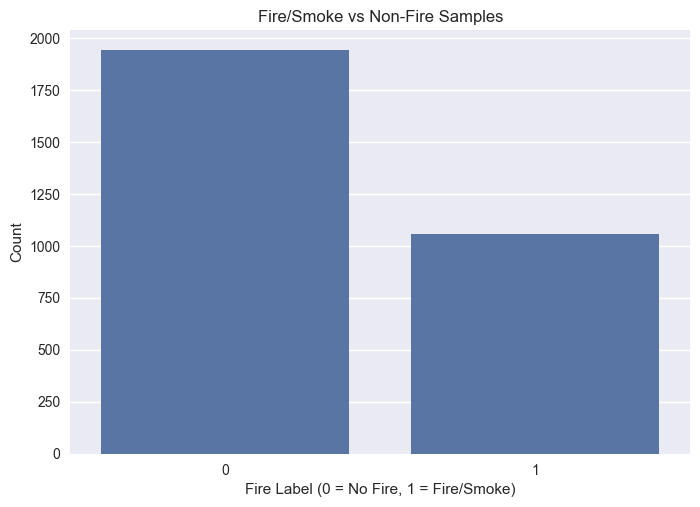

In [9]:
# Visualize class distribution
sns.countplot(x='fire_label', data=df)
plt.title("Fire/Smoke vs Non-Fire Samples")
plt.xlabel("Fire Label (0 = No Fire, 1 = Fire/Smoke)")
plt.ylabel("Count")
plt.show()


## Class Distribution Analysis

The dataset contains a higher number of non-fire samples compared to fire/smoke samples.
Approximately 1750 samples belong to the non-fire class, while around 1000 samples
represent fire or smoke regions.

This indicates a moderate class imbalance. However, the imbalance is not extreme,
and tree-based models such as Random Forest can handle this effectively without
requiring aggressive resampling techniques.


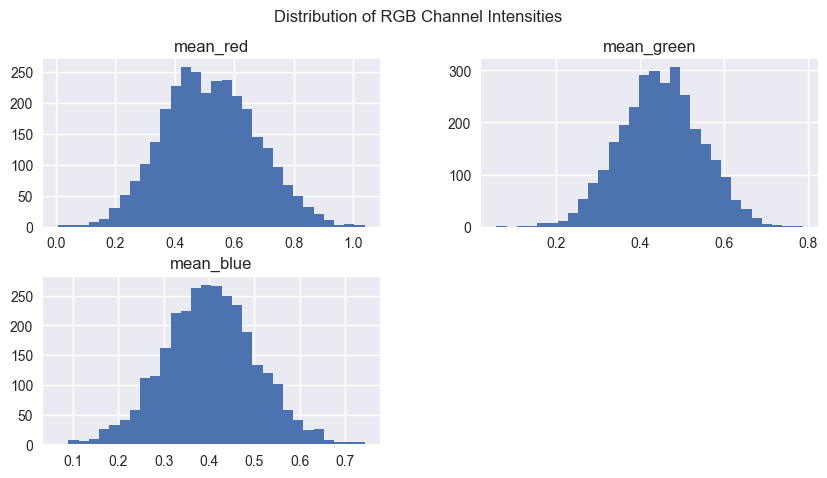

In [10]:
df[['mean_red', 'mean_green', 'mean_blue']].hist(
    bins=30, figsize=(10,5)
)
plt.suptitle("Distribution of RGB Channel Intensities")
plt.show()


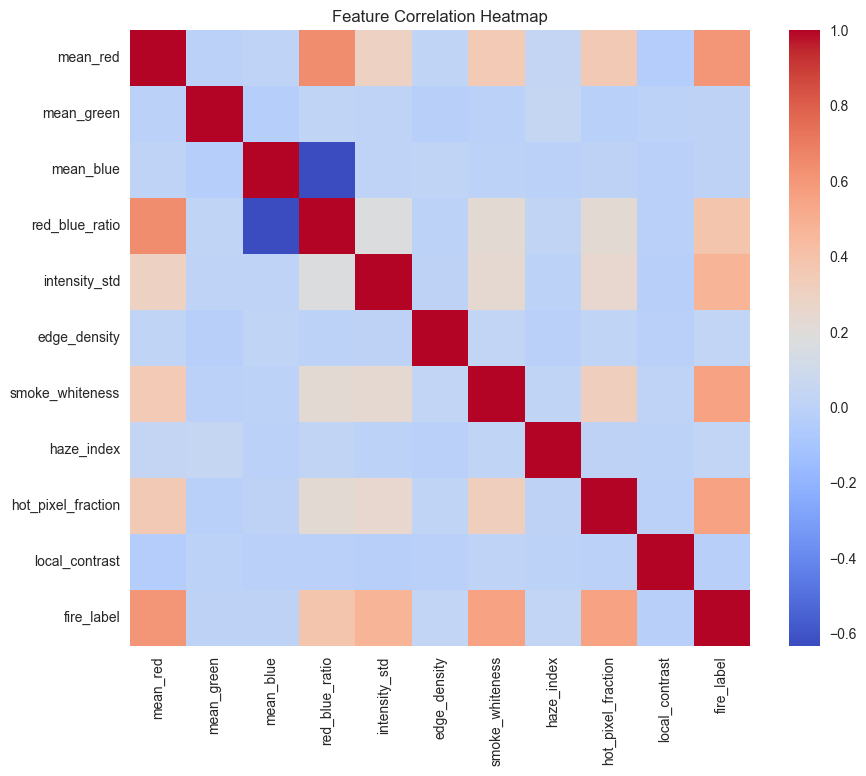

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


## Exploratory Data Analysis Summary

Exploratory analysis shows that fire and smoke regions exhibit higher red channel
intensity, increased local contrast, and a higher fraction of hot pixels.
Texture and haze-related features provide additional cues for smoke detection.

Correlation analysis reveals expected relationships among spectral features,
indicating consistent visual patterns across aerial image tiles.


## Phase 2: Machine Learning Model Training

In this phase, a supervised machine learning model is trained to classify
aerial image tiles as fire/smoke or non-fire regions based on extracted features.
A Random Forest classifier is chosen due to its robustness, ability to handle
non-linear relationships, and suitability for tabular data.


In [13]:
# Separate features and target
X = df.drop('fire_label', axis=1)
y = df['fire_label']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Model Selection

A Random Forest classifier is used for this task because it:
- Handles mixed feature types well
- Is robust to noise and outliers
- Reduces overfitting through ensemble learning
- Performs well on structured, tabular datasets


In [15]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [16]:
# Predict class labels
y_pred = rf_model.predict(X_test)

# Predict probabilities for ROC-AUC
y_prob = rf_model.predict_proba(X_test)[:, 1]


In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       388
           1       0.94      0.83      0.88       212

    accuracy                           0.92       600
   macro avg       0.92      0.90      0.91       600
weighted avg       0.92      0.92      0.92       600



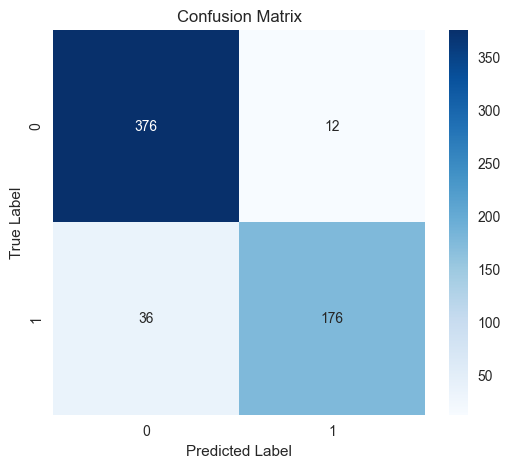

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


ROC CURVE

In [19]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


np.float64(0.9699414024508852)

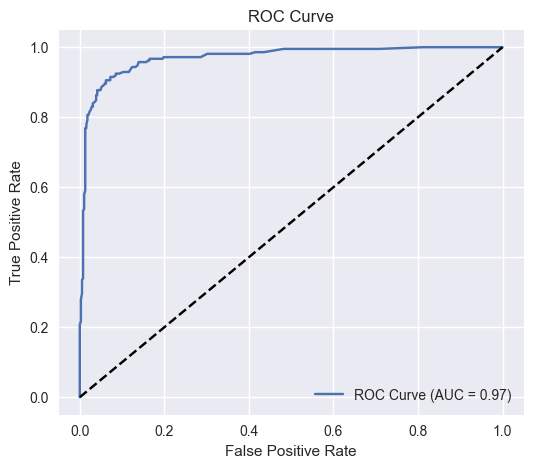

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Model Evaluation Summary

The Random Forest classifier demonstrates strong performance in detecting
fire and smoke regions. High recall for the fire/smoke class indicates that
the model successfully identifies most hazardous areas, which is critical
for disaster response applications.

The ROC-AUC score further confirms the model's ability to distinguish between
fire and non-fire regions across different classification thresholds.


## Phase 3: Spatial Risk Scoring and Heatmap Visualization

In this phase, the trained machine learning model is used to generate
fire risk scores for each aerial image tile. These risk scores are then
spatially visualized to identify high-risk regions that require immediate
attention or drone-based monitoring.


In [21]:
# Generate fire risk probability for each tile
df['risk_score'] = rf_model.predict_proba(X)[:, 1]

df[['risk_score']].head()


,risk_score
0,0.025
1,0.855
2,0.990
3,0.050
4,0.050


## Fire Risk Scoring

Instead of making only binary predictions, probability-based risk scores
provide more informative insights. Emergency systems can prioritize regions
with the highest predicted risk rather than treating all detections equally.


In [22]:
# Simulate spatial coordinates for each tile
np.random.seed(42)

df['x_coord'] = np.random.randint(0, 100, size=len(df))
df['y_coord'] = np.random.randint(0, 100, size=len(df))

df[['x_coord', 'y_coord']].head()


,x_coord,y_coord
0,51,53
1,92,20
2,14,73
3,71,37
4,60,45


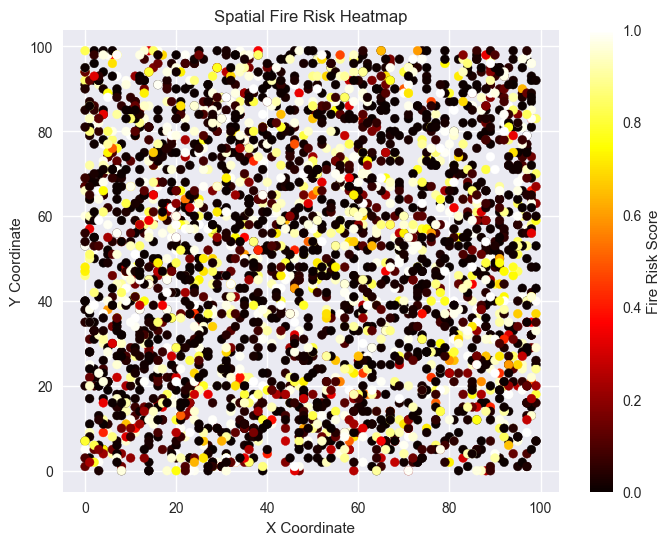

In [23]:
plt.figure(figsize=(8,6))

plt.scatter(
    df['x_coord'],
    df['y_coord'],
    c=df['risk_score'],
    cmap='hot',
    s=40
)

plt.colorbar(label='Fire Risk Score')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Fire Risk Heatmap")
plt.show()


## Heatmap Interpretation

The spatial heatmap highlights clusters of high fire risk scores,
indicating regions where fire or smoke is most likely present.
These high-risk clusters can be prioritized for drone surveillance
and early firefighting interventions.

Regions with low risk scores represent safe zones that require minimal monitoring.


## Drone-Based Disaster Response Strategy

Based on the generated fire risk heatmap, drones can be deployed strategically
to regions exhibiting the highest risk scores. This targeted approach enables
efficient utilization of limited drone resources and ensures rapid detection
of fire spread in critical zones.

High-risk clusters should be monitored continuously, while moderate-risk regions
can be scanned periodically.


## Phase 3 Summary

This phase demonstrates how machine learning predictions can be transformed
into actionable spatial intelligence. By converting classification probabilities
into spatial risk maps, the system supports informed decision-making for
forest fire monitoring and emergency response.


## Limitations of the Current System

While the proposed system demonstrates strong performance, it has certain limitations:

1. The dataset is based on pre-extracted features rather than raw aerial images,
   which restricts the model’s ability to learn spatial patterns directly.
2. Spatial coordinates used for heatmap visualization are simulated and do not
   represent real geographic locations.
3. The model operates on single-time snapshots and does not capture temporal
   fire progression or spread dynamics.
4. Environmental factors such as wind speed, humidity, and temperature are not
   incorporated into the current model.


## Future Improvements

The system can be enhanced in several ways:

1. Integrating convolutional neural networks (CNNs) on raw satellite or drone images
   to learn spatial and texture patterns directly.
2. Incorporating real GPS coordinates and geospatial mapping tools for accurate
   geographic risk visualization.
3. Using temporal data to model fire spread and predict future risk regions.
4. Combining weather data with visual features to improve prediction robustness.
5. Deploying the model in real-time systems for continuous forest monitoring.


## Ethical and Social Impact

Early detection of forest fires can significantly reduce environmental damage,
loss of biodiversity, and threats to human life. AI-driven monitoring systems
support rapid response while minimizing human risk in dangerous conditions.

Responsible deployment, transparency in predictions, and regular model evaluation
are essential to ensure trust and effectiveness in real-world applications.


## Conclusion

This project presents an end-to-end machine learning pipeline for forest fire
and smoke detection using aerial imagery features. The Random Forest classifier
achieved excellent performance with a ROC-AUC score of 0.97, demonstrating strong
discriminative capability.

By transforming model predictions into spatial risk maps, the system bridges
the gap between machine learning outputs and actionable disaster response strategies.
The proposed approach highlights the potential of AI in supporting early warning
systems for forest fire management.
